找到 11 个Excel文件

处理文件: 2025-02-02.xlsx
充电开始点: 时间=2025-02-01 23:08:25, SOC=77.2%
充电结束点: 时间=2025-02-02 00:46:55, SOC=100.0%
总充电时间: 1.64 小时
总充电电量: 64.66 Ah
SOC变化: 77.2% → 100.0% (变化量: 22.8%)
当前最大可用容量: 283.58 Ah
电池额定容量: 352 Ah
SOH: 80.56%
--------------------------------------------------

处理文件: 2025-02-16.xlsx
充电开始点: 时间=2025-02-15 23:05:41, SOC=54.4%
充电结束点: 时间=2025-02-16 02:14:21, SOC=100.0%
总充电时间: 3.14 小时
总充电电量: 132.35 Ah
SOC变化: 54.4% → 100.0% (变化量: 45.6%)
当前最大可用容量: 290.24 Ah
电池额定容量: 352 Ah
SOH: 82.46%
--------------------------------------------------

处理文件: 2025-03-03.xlsx
充电开始点: 时间=2025-03-02 23:09:33, SOC=73.2%
充电结束点: 时间=2025-03-03 01:12:33, SOC=100.0%
总充电时间: 2.05 小时
总充电电量: 80.75 Ah
SOC变化: 73.2% → 100.0% (变化量: 26.8%)
当前最大可用容量: 301.30 Ah
电池额定容量: 352 Ah
SOH: 85.60%
--------------------------------------------------

处理文件: 2025-05-02.xlsx
充电开始点: 时间=2025-05-01 23:17:40, SOC=69.6%
充电结束点: 时间=2025-05-02 01:18:20, SOC=99.2%
总充电时间: 2.01 小时
总充电电量: 80.09 Ah
SOC变化: 69.6% → 99.2% (变化量: 29.6%)
当前最大

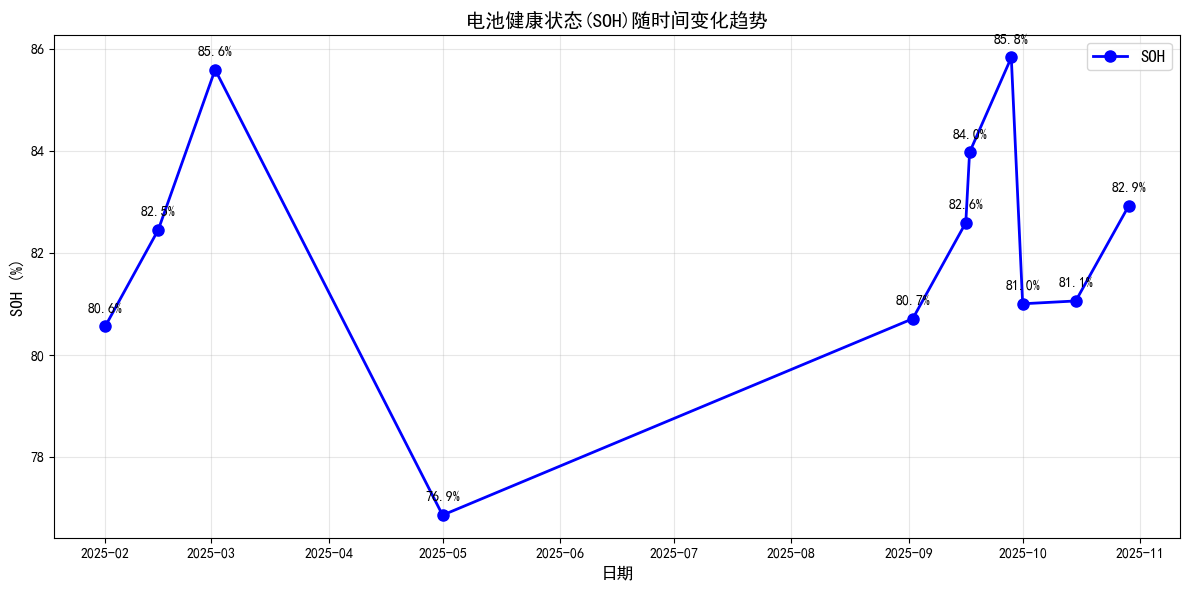


SOH变化趋势汇总
分析文件数量: 11
时间范围: 2025-02-01 至 2025-10-29
SOH范围: 76.86% - 85.83%
平均SOH: 82.14%
SOH变化: 80.56% → 82.93%
SOH日均变化: 0.0088%/天
预计达到80% SOH还需: -334.2 天


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime
import matplotlib.dates as mdates

# 设置中文字体（解决中文显示问题）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

def preprocess_data(df):
    """预处理数据"""
    # 确保时间列是datetime类型
    df['数据时间'] = pd.to_datetime(df['数据时间'])
    
    # 按时间排序
    df = df.sort_values('数据时间').reset_index(drop=True)
    
    return df

def find_charge_start_end(df):
    """找到充电开始点和结束点"""
    
    # 找到SOC最低的点（若有多个，取时间最大的）
    min_soc = df['SOC'].min()
    min_soc_points = df[df['SOC'] == min_soc]
    charge_start = min_soc_points.loc[min_soc_points['数据时间'].idxmax()]
    start_idx = min_soc_points['数据时间'].idxmax()
    
    print(f"充电开始点: 时间={charge_start['数据时间']}, SOC={charge_start['SOC']}%")
    
    # 从开始点往后找，找到SOC的最大值点
    df_after_start = df.iloc[start_idx:]
    max_soc = df_after_start['SOC'].max()
    max_soc_points = df_after_start[df_after_start['SOC'] == max_soc]
    
    # 取时间顺序最小的那个点作为充电结束点
    charge_end = max_soc_points.loc[max_soc_points['数据时间'].idxmin()]
    end_idx = max_soc_points['数据时间'].idxmin()
    
    print(f"充电结束点: 时间={charge_end['数据时间']}, SOC={charge_end['SOC']}%")
    
    # 提取充电段数据
    charge_data = df.iloc[start_idx:end_idx+1].copy()
    
    return charge_start, charge_end, charge_data

def calculate_soh(charge_data, rated_capacity=352):
    """计算SOH"""
    
    # 计算时间间隔（小时）
    charge_data['时间差_小时'] = charge_data['数据时间'].diff().dt.total_seconds() / 3600
    
    # 第一行的时间差设为0
    charge_data.loc[charge_data.index[0], '时间差_小时'] = 0
    
    # 计算每个时间段的充电电量（Ah），电流取绝对值
    charge_data['充电电量_Ah'] = abs(charge_data['充放电电流']) * charge_data['时间差_小时']
    
    # 总充电电量
    total_charge_ah = charge_data['充电电量_Ah'].sum()
    
    # SOC变化量
    soc_start = charge_data.iloc[0]['SOC']
    soc_end = charge_data.iloc[-1]['SOC']
    soc_change = soc_end - soc_start
    
    print(f"总充电时间: {charge_data['时间差_小时'].sum():.2f} 小时")
    print(f"总充电电量: {total_charge_ah:.2f} Ah")
    print(f"SOC变化: {soc_start:.1f}% → {soc_end:.1f}% (变化量: {soc_change:.1f}%)")
    
    # 计算当前最大可用容量
    if soc_change > 0:
        current_capacity = (total_charge_ah / soc_change) * 100
    else:
        current_capacity = rated_capacity  # 如果SOC没变化，使用额定容量
    
    # 计算SOH
    soh = (current_capacity / rated_capacity) * 100
    
    print(f"当前最大可用容量: {current_capacity:.2f} Ah")
    print(f"电池额定容量: {rated_capacity} Ah")
    print(f"SOH: {soh:.2f}%")
    print("-" * 50)
    
    return soh, current_capacity, total_charge_ah, soc_change, soc_start, soc_end

def process_single_file(file_path):
    """处理单个文件并计算SOH"""
    print(f"\n处理文件: {os.path.basename(file_path)}")
    
    try:
        # 读取Excel文件
        df = pd.read_excel(file_path)
        
        # 预处理数据
        df = preprocess_data(df)
        
        # 找到充电开始和结束点
        charge_start, charge_end, charge_data = find_charge_start_end(df)
        
        # 获取额定容量
        rated_capacity = df['电池系统额定容量'].iloc[0]
        
        # 计算SOH
        soh, current_capacity, total_charge, soc_change, soc_start, soc_end = calculate_soh(charge_data, rated_capacity)
        
        # 获取文件日期（用于时间排序）
        file_date = charge_start['数据时间'].date()
        
        return {
            'file_name': os.path.basename(file_path),
            'date': file_date,
            'soh': soh,
            'current_capacity': current_capacity,
            'rated_capacity': rated_capacity,
            'charge_start': charge_start['数据时间'],
            'charge_end': charge_end['数据时间'],
            'soc_start': soc_start,
            'soc_end': soc_end,
            'total_charge_ah': total_charge
        }
    
    except Exception as e:
        print(f"处理文件 {file_path} 时出错: {e}")
        import traceback
        traceback.print_exc()  # 打印详细错误信息
        return None

def visualize_soh_trend(soh_results):
    """可视化SOH随时间变化趋势"""
    if not soh_results:
        print("没有有效的结果可以可视化")
        return
    
    # 按日期排序
    soh_results.sort(key=lambda x: x['date'])
    
    # 提取数据
    dates = [result['date'] for result in soh_results]
    soh_values = [result['soh'] for result in soh_results]
    current_capacities = [result['current_capacity'] for result in soh_results]
    rated_capacity = soh_results[0]['rated_capacity']  # 假设所有文件额定容量相同
    
    # 创建图表 - 现在只有一个图
    plt.figure(figsize=(12, 6))
    
    # SOH趋势图
    plt.plot(dates, soh_values, 'bo-', linewidth=2, markersize=8, label='SOH')
    plt.title('电池健康状态(SOH)随时间变化趋势', fontsize=14, fontweight='bold')
    plt.ylabel('SOH (%)', fontsize=12)
    plt.xlabel('日期', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # 添加数据标签
    for i, (date, soh) in enumerate(zip(dates, soh_values)):
        plt.annotate(f'{soh:.1f}%', 
                    (date, soh),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=10)
    
    # 调整布局
    plt.tight_layout()
    
    # 确保图表显示
    plt.show(block=True)
    
    # 打印汇总统计
    print("\n" + "="*60)
    print("SOH变化趋势汇总")
    print("="*60)
    print(f"分析文件数量: {len(soh_results)}")
    print(f"时间范围: {dates[0]} 至 {dates[-1]}")
    print(f"SOH范围: {min(soh_values):.2f}% - {max(soh_values):.2f}%")
    print(f"平均SOH: {np.mean(soh_values):.2f}%")
    print(f"SOH变化: {soh_values[0]:.2f}% → {soh_values[-1]:.2f}%")
    
    if len(soh_values) > 1:
        soh_change = soh_values[-1] - soh_values[0]
        days_diff = (dates[-1] - dates[0]).days
        if days_diff > 0:
            daily_change = soh_change / days_diff
            print(f"SOH日均变化: {daily_change:.4f}%/天")
            print(f"预计达到80% SOH还需: {(80 - soh_values[-1]) / daily_change:.1f} 天")
    
    return soh_results

def main():
    """主函数 - 处理多个Excel文件"""
    
    # 设置Excel文件路径模式（根据实际情况修改）
    # 示例：处理当前目录下所有.xlsx文件
    file_pattern = "battery_data/*.xlsx"  # 根据你的目录结构调整
    
    # 获取所有Excel文件
    excel_files = glob.glob(file_pattern)
    
    if not excel_files:
        print(f"没有找到匹配 {file_pattern} 的Excel文件")
        print("请确保：")
        print("1. 文件在当前目录或指定目录中")
        print("2. 文件扩展名为.xlsx")
        return
    
    print(f"找到 {len(excel_files)} 个Excel文件")
    
    # 处理每个文件
    soh_results = []
    for file_path in excel_files:
        result = process_single_file(file_path)
        if result:
            soh_results.append(result)
    
    # 可视化结果
    if soh_results:
        final_results = visualize_soh_trend(soh_results)
    else:
        print("没有成功处理任何文件")

# 运行主程序
if __name__ == "__main__":
    main()